# Homework 6 Solution

**MECH.5130: Theory of Finite Element Analysis**

Michael N. Olaya

## Problem 1

Connectivity $[G]$ for the assembly, where the row index is the element number and the column index is the associated local node numbers. Each element of the $[G]$ refers to a global node number on an element.

$$
[G] =
\begin{bmatrix}
1 & 2 & 5 \\
3 & 4 & 6 & 5 \\
4 & 7 \\
\end{bmatrix}
$$

![hw6_p2](../figs/hw6_p1.png)

## Problem 2

Connectivity $[G]$ for the assembly, where the row index is the element number and the column index is the associated local node numbers. Each element of the $[G]$ refers to a global node number on an element.

$$
[G] =
\begin{bmatrix}
12 & 9 & 10 \\
3 & 8 & 4 & 12 & 6 & 2 & 5 & 1 \\
6 & 7 \\
4 & 11 \\
\end{bmatrix}
$$

![hw6_p2](../figs/hw6_p2.png)

## Problem 3

Generally, the "rules" for element/node numbering in Abaqus are:

- Elements numbered in a CCW fashion (top to bottom, right to left)
- Global node numbers applied element-by-element in element order
- Number corner nodes first, then number intermediate nodes

## Problem 4

![key_funcs](../figs/hw6_funcs.png)
![bubble_charts](../figs/hw6_bubblechart.png)

## Problem 5

### assemble_mesh

```Python
# Input: 
    # G: ndarray (num_elems x max(num_nodes))
    # node_coords: ndarray (num_nodes x 2)
# For each elemental row in G...
    # Get indices of node coords matching global nodes for the element
    # Get node coords at corresponding indices
    # Construct element
    # Add element to list of elements in assembly
# Output: 
    # list[mfe.baseclasses.Element2D]
```

### assemble_global_solution

```Python
# Input: 
    # G: ndarray (num_elems x max(num_nodes))
    # elems: list[mfe.baseclasses.Element2D]
    # loads: list[mfe.load.SurfaceTraction]
# For each elemental row in G...
    # Get corresponding element from assembly
    # Compute element stiffness matrix and load vector
    # For each node in element
        # For each dof of node
            # Get indices linking local row to global row of stiffness/force
            # Update global force vector: F[iglobal_row, 0] = F[iglobal_row, 0] + f[ilocal_row, 0]
            # For each node in element
                # For each dof on node
                    # Get indices linking local column to global column of stiffness
                    # Update global stiffness matrix
                    # K[iglobal_row, iglobal_col] = K[iglobal_row, iglobal_col] + k[ilocal_row, ilocal_col]
# Output: 
    # np.ndarray (ndof*num_nodes x ndof*num_nodes)
    # np.ndarray (ndof*num_nodes x 1)
```

## Problem 6

In [1]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import mfe.baseclasses
import mfe.solve
import mfe.utils
import mfe.load
import mfe.plot

MESH_FILES = {
    'connectivity': pathlib.Path('p6_connectivity.csv'),
    'node_coords': pathlib.Path('p6_nodes.csv')
}

In [2]:
# Get connectivity matrix and nodal coordinates, then assemble the mesh
G, node_coords = mfe.utils.read_mesh_from_csv(**MESH_FILES)
elems = mfe.solve.assemble_mesh(G, node_coords)

# Set the element material property matrix and thickness
D = mfe.baseclasses.Material(E=70000, nu=0.33).D_isotropic_plane_stress()
thickness = 0.3
for e in elems:
    e.D = D.copy()
    e.thickness = thickness

# Set the traction boundary conditions corresponding to elements 1 and 2
loads = [[] for _ in elems]
loads[0] = mfe.load.SurfaceTraction.generate(elems[0], '+y', [np.array([0]), np.array([15])], thickness=elems[0].thickness)
loads[1] = mfe.load.SurfaceTraction.generate(elems[1], '+y', [np.array([0]), np.array([15])], thickness=elems[1].thickness)

# Assemble solution matrices
K, F = mfe.solve.assemble_global_solution(G, elems, loads, 2)

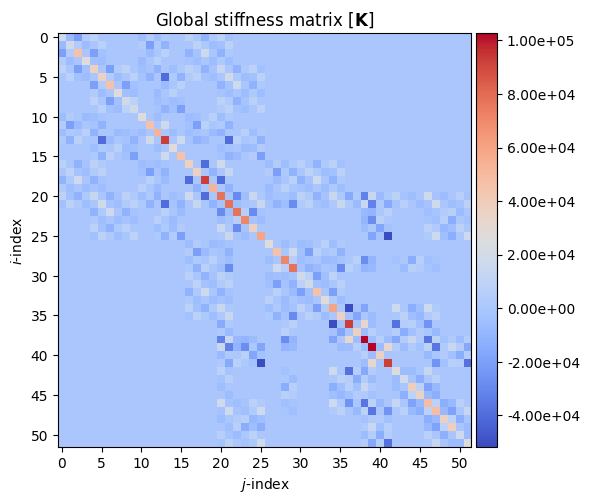

In [3]:
# Plot solution
fig, ax = plt.subplots(figsize=(6, 6))
cbar = mfe.plot.plot_stiffness_heatmap(fig, ax, K, cmap='coolwarm', label_every=5)
ax.set_title(r'Global stiffness matrix $[\mathbf{K}]$')
fig.tight_layout()